# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [54]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

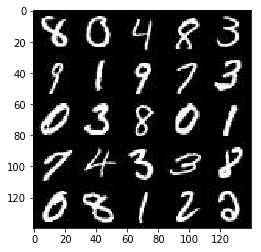

In [55]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

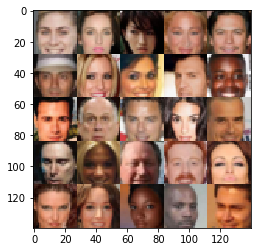

In [56]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/darren/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [58]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [59]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xc
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        d1 = tf.layers.dropout(inputs=x1, rate=0.5, training=True)
        relu1 = tf.maximum(alpha * d1, d1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        d2 = tf.layers.dropout(inputs=bn2, rate=0.5, training=True)
        relu2 = tf.maximum(alpha * d2, d2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        d3 = tf.layers.dropout(inputs=bn3, rate=0.5, training=True)
        relu3 = tf.maximum(alpha * d3, d3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        dropout = tf.layers.dropout(inputs=logits, rate=0.5, training=True)
        output = tf.sigmoid(dropout)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * (1 - smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [62]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [64]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """

Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 320
    show_every = 100
    n_images = 6
    
    image_width = list(data_shape)[1]
    image_height = list(data_shape)[2]
    image_channels = list(data_shape)[3]

    input_real, input_z, _ = model_inputs(image_width,
                                        image_height,
                                        image_channels,
                                        z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

            show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2825... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.3374
Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 0.4154... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 3.8243... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 1.4328
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.3252
Epoch 1/2... Discriminator Loss: 2.2066... Generator Loss: 0.6407
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 1.7979
Epoch 1/2... Discriminator Loss: 2.5958... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.3401
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.0114
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 2.4731
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.8002
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 2.2984
Epoch 1/2... Discriminator Loss: 0.7010... Generator Loss: 2.6254
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 2.3577
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 1.0058... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 2.7752
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.5924
Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 1.5727
Epoch 1/2... Discriminator Loss: 2.4261... Generator Loss: 1.3624
Epoch 1/2.

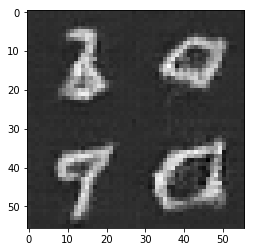

Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 1.7758... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 1.7248... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 2.7546
Epoch 2/2... Discriminator Loss: 2.5297... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.1821
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.4045
Epoch 2/2... Discriminator Loss: 1.4865... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 0.9808
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 0.4110
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.3118
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 2.2249
Epoch 2/2... Discriminator Loss: 0.6809... Generator Loss: 0.7008
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 2.9651
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.0892
Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 2.4030
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 2.0631... Generator Loss: 1.2139
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.4574
Epoch 2/2... Discriminator Loss: 2.0963... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 0.6409... Generator Loss: 2.1396
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 1.9098
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 1.5999... Generator Loss: 1.1366
Epoch 2/2.

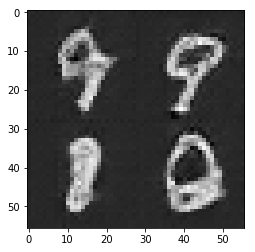

In [65]:
batch_size = 1
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1834... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 3.1770
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.1463
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 5.4310
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 4.6990
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 2.7455
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 1.8272
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 1.8146
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 1.7437
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.3754
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 1.7652
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.9028
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 1.5452
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 2.0411... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 0.8352
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 2.5060... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.7539... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.8046... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.8897
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.7165... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.8807
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.7258... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.5166
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.8436... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.7558


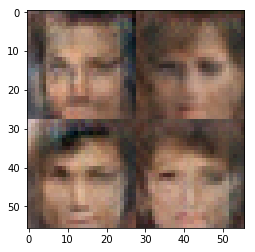

In [67]:
batch_size = 1
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.